# Load Dependencies


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import copy

from pyciemss.PetriNetODE.interfaces import setup_model, intervene, sample, calibrate, optimize
from pyciemss.utils import get_tspan
from pyciemss.utils import setup_ax, plot_predictive, plot_trajectory, plot_intervention_line, plot_ouu_risk

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import scenario2dec_nday_average

import warnings
warnings.filterwarnings('ignore')

# Setup parameters


In [2]:
full_tspan = torch.tensor([float(x) for x in list(range(1,90))])

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1 (there will not be zero recovered people when there are 81 infectious people)
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs_data = [81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31] #these numbers make no sense, why not use whole numbers?
plot_I_obs = dict(I_obs=torch.tensor(I_obs_data))
I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate(I_obs_data)]
observed_tspan = torch.tensor([float(x) for x in list(range(1,len(I_obs)+1))])

# Probabilistic forecasting - ignoring any observed data

### Load the model

In [3]:
from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
model_json = '../../test/models/SVIIvR_mira.json'
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira(model_json)
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

MIRA_I_obs_with_scaled_Gaussian_noise(
	beta = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	betaV = Uniform(low: 0.03375000134110451, high: 0.04125000163912773),
	nu = Uniform(low: 0.0044999998062849045, high: 0.005499999970197678),
	gamma = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	gammaV = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	total_population = 100000.0,
	data_reliability = 4.0
)

### Initialize model

In [4]:
initialized_petri_net_ode_model = setup_model(petri_net_ode_model, start_time=0.0, start_state=dict(S=S0, V=V0, I=I0, I_v=Iv0, R=R0))

## Q: "What likely future outcomes does our model imply while ignoring observed Data?"

### Sample a single trajectory from the prior distribution

In [5]:
single_prior = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=1)
single_prior['I_obs'] = single_prior['I_sol'] + single_prior['I_v_sol']

### Sample 100 trajectories from the prior distribution

In [6]:
prior_prediction = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=100)
prior_prediction['I_obs'] = prior_prediction['I_sol'] + prior_prediction['I_v_sol']

### Plot trajectories using prior information only

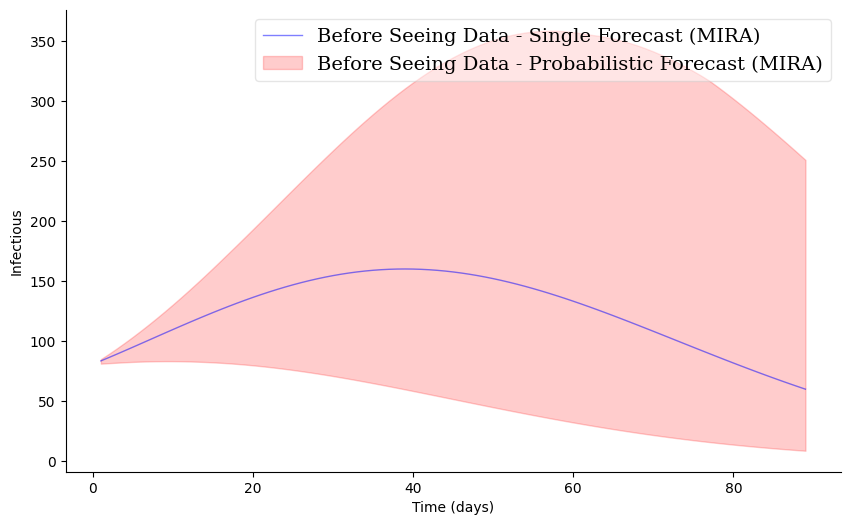

In [7]:
ax = plot_trajectory(single_prior, full_tspan, color="blue", label="Before Seeing Data - Single Forecast (MIRA)", marker='', lw=1.)
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (MIRA)", color="red", alpha=0.2)

## Probabibilistic forecasting - incorporating observed data

### Calibration

In [8]:
data = [(float(i+1), dict(I_obs=obs)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]
calibrated_parameters = calibrate(initialized_petri_net_ode_model, data=data, verbose=True)

iteration 0: loss = 27.92705750465393
iteration 25: loss = 22.128242254257202
iteration 50: loss = 20.624025464057922
iteration 75: loss = 17.849794387817383
iteration 100: loss = 19.361363649368286
iteration 125: loss = 17.52364230155945
iteration 150: loss = 17.307059049606323
iteration 175: loss = 16.35046362876892
iteration 200: loss = 16.563122034072876
iteration 225: loss = 15.544377565383911
iteration 250: loss = 17.02051329612732
iteration 275: loss = 15.28451657295227
iteration 300: loss = 16.077346563339233
iteration 325: loss = 17.566938161849976
iteration 350: loss = 15.939857721328735
iteration 375: loss = 14.26394534111023
iteration 400: loss = 15.940684080123901
iteration 425: loss = 15.52432370185852
iteration 450: loss = 15.819238901138306
iteration 475: loss = 14.000469446182251
iteration 500: loss = 15.902226686477661
iteration 525: loss = 17.258690118789673
iteration 550: loss = 15.24609923362732
iteration 575: loss = 15.901126623153687
iteration 600: loss = 15.3250

### Samples from the calibrated parameters

In [9]:
posterior_prediction = sample(initialized_petri_net_ode_model,  inferred_parameters=calibrated_parameters, timepoints=full_tspan, num_samples=100)
posterior_prediction['I_obs'] = posterior_prediction['I_sol'] + posterior_prediction['I_v_sol']
single_posterior = sample(initialized_petri_net_ode_model,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=1)
single_posterior['I_obs'] = single_posterior['I_sol'] + single_posterior['I_v_sol']

## Q: "What future outcomes are likely given the data we've seen?"

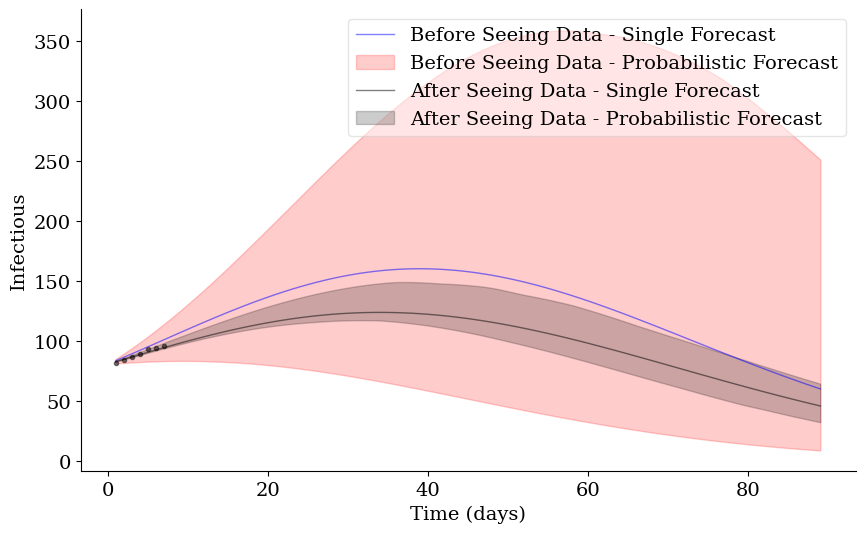

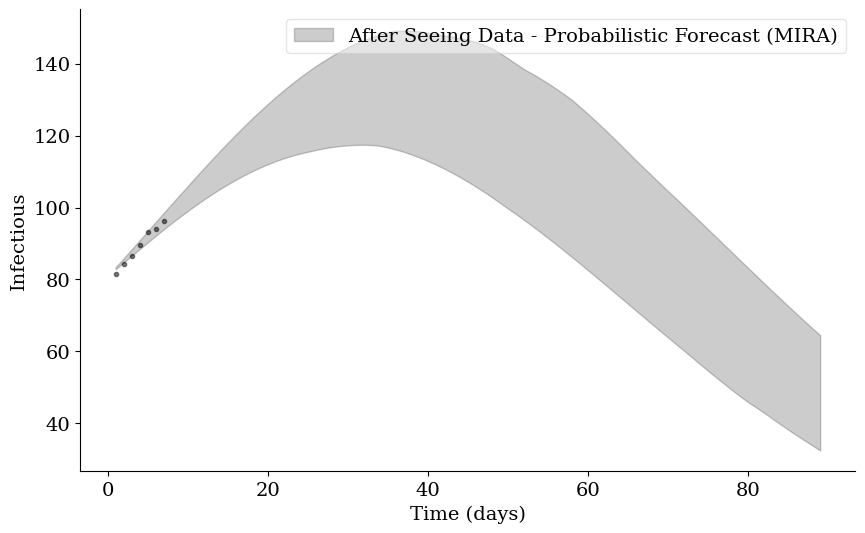

In [10]:
ax = plot_trajectory(plot_I_obs, get_tspan(1, len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_trajectory(single_prior, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, full_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (MIRA)")

# Probabilistic forecasting - exploring possible interventions



## Q: "What would happen if we set the vaccination rate parameter, $\nu$, to 0.01 after 7.5 days?"


In [11]:
# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
rate_parameter_intervention = [(7.5, "nu", 0.01)]
num_samples = 100
intervened_parameter_model = intervene(initialized_petri_net_ode_model, rate_parameter_intervention)
intervened_parameter_prediction = sample(intervened_parameter_model, full_tspan, num_samples, calibrated_parameters)
intervened_parameter_prediction['I_obs'] = intervened_parameter_prediction['I_sol'] + intervened_parameter_prediction['I_v_sol']

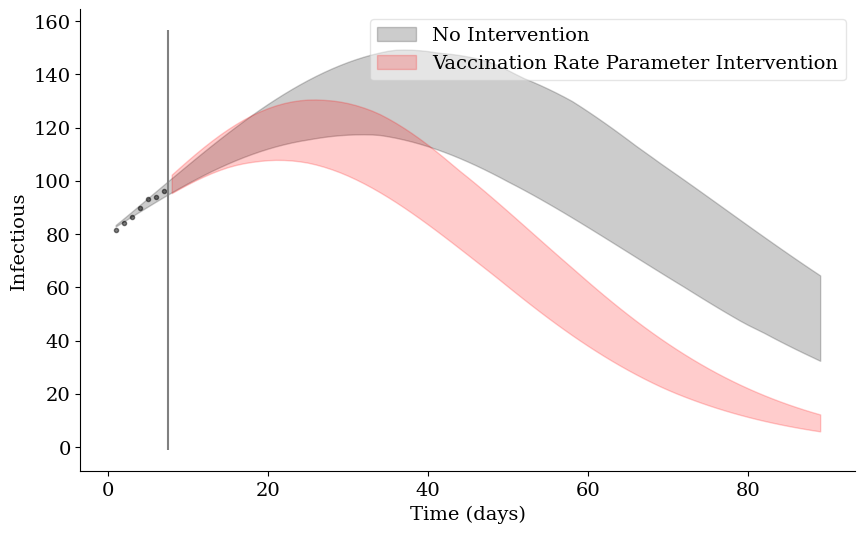

In [12]:
ax = setup_ax()
ax = plot_trajectory(plot_I_obs, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, full_tspan, tmin=7.5, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7.5, ax=ax)

# Risk-based optimization under uncertainty (OUU)
## Q: "What is the minimal vaccination policy that results in less than 10 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections, $\mathcal{R}( M(\mathbf{u}, \theta))$, exceeding the prescribed threshold of 10 is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

### Exploring the intervention on $\nu$ to highlight the difference between Quantiles and Superquantiles

In [13]:
control_model = copy.deepcopy(initialized_petri_net_ode_model)
INTERVENTION= {"intervention1": [7.5, "nu"]} # Control action / intervention
QOI = lambda y: scenario2dec_nday_average(y, contexts=["I_obs"], ndays=7)
POLICY = 0.01
N_SAMPLES = 100
RISK = computeRisk(model=control_model,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_measure=alpha_superquantile,
                   num_samples=N_SAMPLES,
                   tspan=full_tspan,
                   guide=calibrated_parameters)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
# Estimate QoI
sq_qoi = RISK.qoi(sq_dataCube)
# Estimate superquantile risk
sq_sv = RISK.risk_measure(sq_qoi)
# Estimate quantile risk
RISK.risk_measure = alpha_quantile
q_sv = RISK.risk_measure(sq_qoi)
print('quantile: ', q_sv, '\nalpha-superquantile: ', sq_sv)

Forward UQ took 58.09 seconds total (5.81e-01 seconds per model evaluation).
quantile:  14.966228199005126 
alpha-superquantile:  16.36622848510742


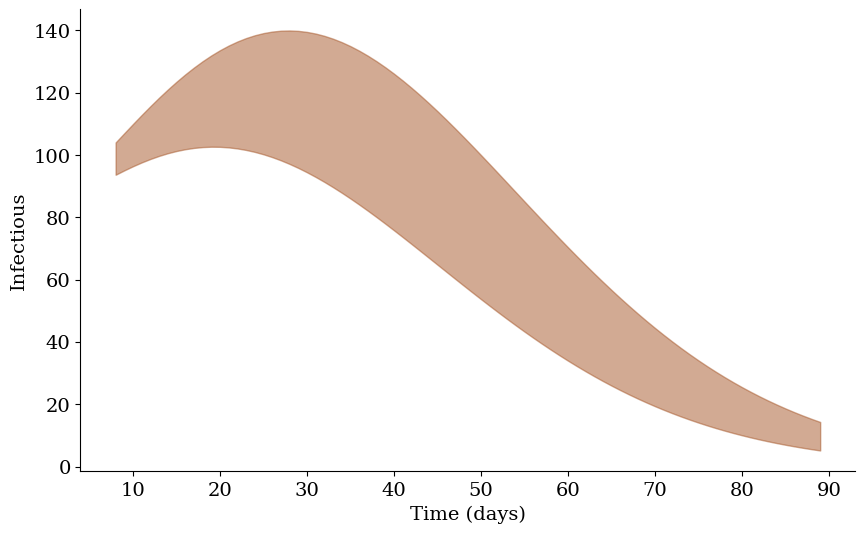

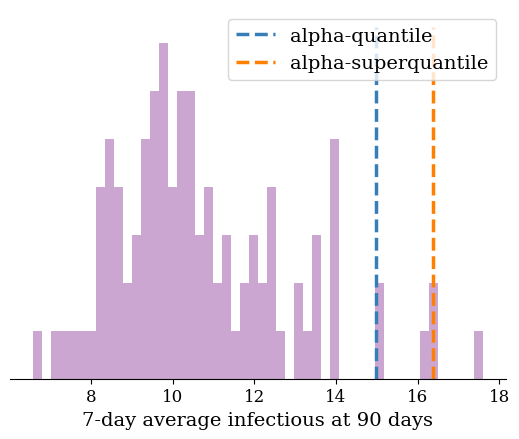

In [14]:
risk_results = {"risk": [q_sv, sq_sv], "samples": sq_dataCube, "qoi": sq_qoi, "tspan": RISK.tspan}
ax1 = plot_ouu_risk(risk_results, color=['#377eb8', '#ff7f00'], label=['alpha-quantile','alpha-superquantile'], tmin=7.5)

### Setup and run OUU problem
**NOTE:** This is a demonstration of the interface. The optimizer can be run with higher maximum iterations, maximum function evaluations, and number of samples to accurately estimate the risk to achieve better convergence of the optimization results.

In [15]:
INTERVENTION= {"VaccinationParam": [7.5, "nu"]}
QOI = lambda y: scenario2dec_nday_average(y, contexts=["I_obs"], ndays=7)
timepoints_qoi = range(83,90)
ouu_policy = optimize(initialized_petri_net_ode_model,
                   timepoints=timepoints_qoi,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_bound=10.,
                   initial_guess=0.025,
                   bounds=[[0.],[3.]],
                   n_samples_ouu=int(1e2),
                   maxiter=2,
                   maxfeval=20,
                   inferred_parameters=calibrated_parameters)

Time taken: (1.66e+00 seconds per model evaluation).
Performing risk-based optimization under uncertainty (using alpha-superquantile)
Estimated wait time 9937.6 seconds...
Optimization completed in time 2182.52 seconds.
Optimal policy:	0.0119
Post-processing optimal policy...
Estimated risk at optimal policy [10.5205]


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\nu^*=0.0122$

Text(0.5, 1.0, 'Optimal $\\nu$ parameter intervention\nwith risk-based OUU')

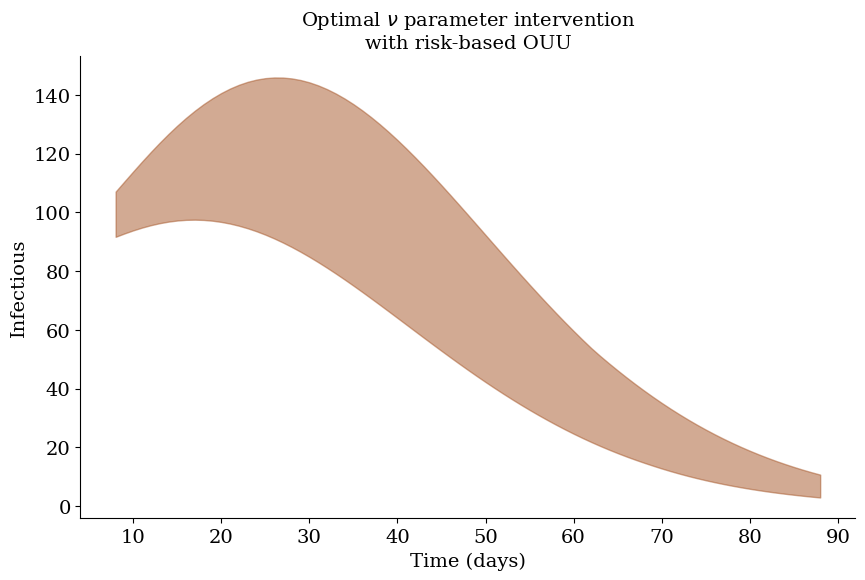

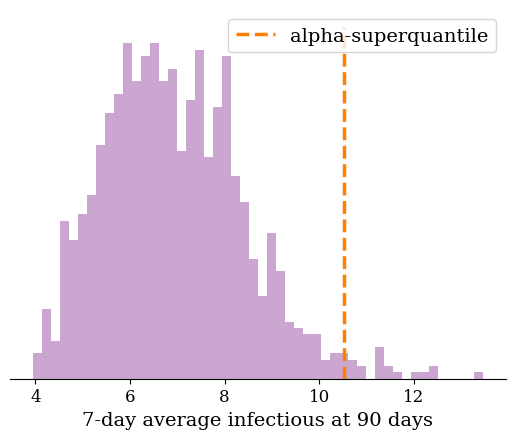

In [16]:
ouu_policy["risk"] = [ouu_policy["risk"]]
ax = plot_ouu_risk(ouu_policy, color=['#ff7f00'], tmin=7.5)
ax[0].set_title(r"Optimal $\nu$ parameter intervention"+ "\n" + r"with risk-based OUU", size=14)